In [9]:
from efficient_probit_regression import settings
from efficient_probit_regression.datasets import BaseDataset, Covertype, KDDCup, Webspam, Synthetic, Diabetes, SyntheticSimplexGaussian

from scipy.stats import median_abs_deviation

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np

import seaborn as sns

In [10]:
if not settings.PLOTS_DIR.exists():
    settings.PLOTS_DIR.mkdir()

In [11]:
def get_results_df(dataset: BaseDataset, p, methods):
    df_list = []

    for method in methods:
        df = (
            pd.read_csv(settings.get_results_dir_p(p) / (dataset.get_name() + f"_{method}.csv"))
            .filter(items=["ratio", "size", "total_time_s"])
            .groupby(["size"], as_index=False)
            .agg(
                median_ratio = pd.NamedAgg(column="ratio", aggfunc="median"), 
                std  = pd.NamedAgg(column="ratio", aggfunc="std"),
                stdFinite  = pd.NamedAgg(column="ratio", aggfunc=lambda x: x[np.isfinite(x)].std()),
                mad  = pd.NamedAgg(column="ratio", aggfunc=median_abs_deviation),
                q75  = pd.NamedAgg(column="ratio", aggfunc=lambda x: np.quantile(x, q=0.75)),
                q25  = pd.NamedAgg(column="ratio", aggfunc=lambda x: np.quantile(x, q=0.25)),
                count = pd.NamedAgg(column="ratio", aggfunc="size"),
                median_total_time_s = pd.NamedAgg(column="total_time_s", aggfunc="median"), 
            )
            .assign(method=method)
        )
        df_list.append(df)

    return(pd.concat(df_list, ignore_index=True))

In [12]:
def make_ratio_plot(dataset, p, methods, x_min, x_max, y_min, y_max, plot_bands=True, font_size=15, font_size_title=23):
    results_df = get_results_df(dataset, p, methods)

    # use TeX for typesetting
    plt.rcParams["text.usetex"] = True
    plt.rc("font", size=font_size)

    fig, ax = plt.subplots()

    colormap = matplotlib.cm.get_cmap(name="tab20")
    colors = {
        "uniform": colormap(0),
        "logit": colormap(2),
        "lewis": colormap(4),
        "lewis-fast": colormap(4),
        "leverage": colormap(6),
        "leverage_online": colormap(8),
    }

    labels = {
        "uniform": "uniform",
        "logit": "root l2",
        "lewis": "Lewis",
        "lewis-fast": "lewis l1",
        "leverage": f"{p}-Poisson",
        "leverage_online": f"online l2",
    }

    titles = {
        "covertype": f"Covertype, p={p}",
        "kddcup": f"Kddcup, p={p}",
        "webspam": f"Webspam, p={p}",
        f"synthetic_n100000_d6_p{p}_variant1_seed2": f"Synthetic I, p={p}",
        f"synthetic_n100000_d6_p{p}_variant2_seed2": f"Synthetic II, p={p}",
        f"syntheticSimplexGaussian_n100000_d6_p{p}_variant1_seed3": f"Synthetic, p={p}",
        f"syntheticSimplexGaussian_n100000_d6_p{p}_variant2_seed3": f"Synthetic, p={p}",
        f"diabetes": f"Diabetes, p={p}",
    }

    for cur_method in methods:
        cur_results = results_df.loc[results_df["method"] == cur_method]
        ax.plot(
            cur_results["size"], 
            cur_results["median_ratio"],
            color=colors[cur_method],
            label=labels[cur_method],
        )
        if plot_bands:
            lower = cur_results["median_ratio"] - 2 * cur_results["stdFinite"] / np.sqrt(cur_results["count"])
            upper = cur_results["median_ratio"] + 2 * cur_results["std"] / np.sqrt(cur_results["count"])
            upper = pd.Series(upper).fillna(1e10)
            ax.fill_between(
                cur_results["size"],
                #(cur_results["q25"] - cur_results["median_ratio"]) * 0.7413 + cur_results["median_ratio"],
                #(cur_results["q75"] - cur_results["median_ratio"]) * 0.7413 + cur_results["median_ratio"],
                # cur_results["q25"],
                # cur_results["q75"],
                lower,
                upper,
                color=colors[cur_method],
                alpha=0.3, interpolate=True
            )

    ax.set_xlim(left=x_min, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)

    ax.set_xlabel("reduced size")
    ax.set_ylabel("median approximation ratio")

    ax.set_title(titles[dataset.get_name()], fontsize=font_size_title)

    legend = ax.legend(loc="upper right", frameon=True)

    fig.tight_layout()

    plt.savefig(settings.PLOTS_DIR / f"{dataset.get_name()}_ratio_plot_p_{p}.pdf", dpi=fig.dpi)
    plt.show()
    plt.close(fig)

In [13]:
def make_runtime_plot(dataset, p, methods, x_min, x_max, y_min, y_max, draw_line=False, font_size=15, font_size_title=23):
    results_df = get_results_df(dataset, p, methods)

    # use TeX for typesetting
    plt.rcParams["text.usetex"] = True
    plt.rc("font", size=font_size)

    fig, ax = plt.subplots()

    colormap = matplotlib.cm.get_cmap(name="tab20")
    colors = {
        "uniform": colormap(0),
        "logit": colormap(2),
        "lewis": colormap(4),
        "lewis-fast": colormap(4),
        "leverage": colormap(6),
        "leverage_online": colormap(8),
    }

    labels = {
        "uniform": "uniform",
        "logit": "root l2",
        "lewis": "Lewis",
        "lewis-fast": "lewis l1",
        "leverage": f"{p}-probit",
        "leverage_online": f"online l2",
    }

    titles = {
        "covertype": f"Covertype, p={p}",
        "kddcup": f"Kddcup, p={p}",
        "webspam": f"Webspam, p={p}",
    }

    for cur_method in methods:
        cur_results = results_df.loc[results_df["method"] == cur_method]

        if not draw_line:
            ax.scatter(
                cur_results["median_total_time_s"],
                cur_results["median_ratio"], 
                color=colors[cur_method],
                label=labels[cur_method],
            )
        else:
            cur_results = cur_results.sort_values(by="median_total_time_s")
            ax.plot(
                cur_results["median_total_time_s"],
                cur_results["median_ratio"], 
                color=colors[cur_method],
                label=labels[cur_method],
            )

    ax.set_xlim(left=x_min, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)

    ax.set_ylabel("median approximation ratio")
    ax.set_xlabel("median running time (s)")

    ax.set_title(titles[dataset.get_name()], fontsize=font_size_title)

    legend = ax.legend(loc="upper right", frameon=True)

    fig.tight_layout()

    add_line_str = ""
    if draw_line:
        add_line_str = "_line"

    plt.savefig(settings.PLOTS_DIR / f"{dataset.get_name()}_runtime_plot_p_{p}.pdf")

    plt.show()

# make_runtime_plot(Covertype(), p=1, methods=["uniform", "logit", "lewis", "leverage"], x_min=0, x_max=None, y_min=1, y_max=1.04, draw_line=True)

C:\Users\Traitor\AppData\Local\Temp\ipykernel_11056\2005496796.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap(name="tab20")


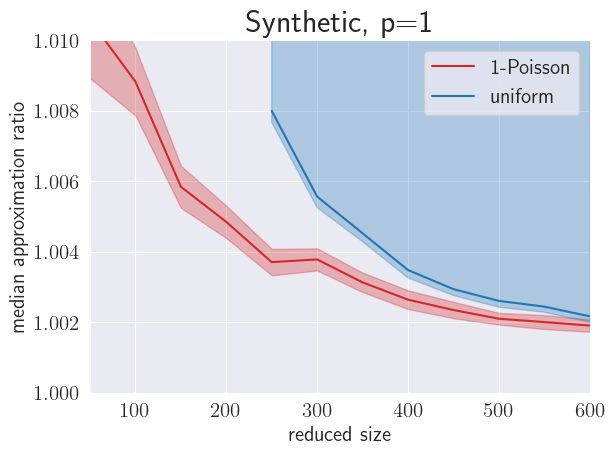

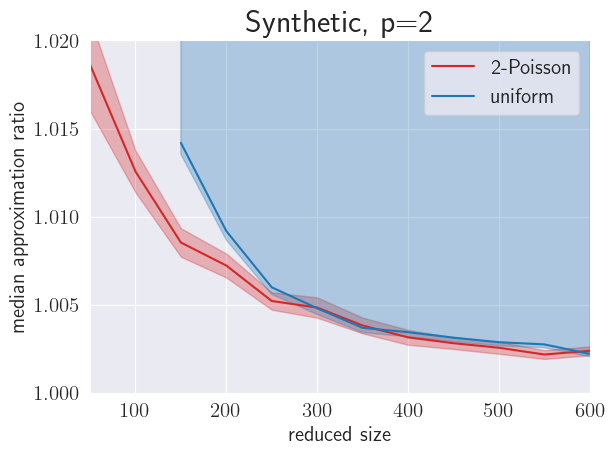

In [14]:
make_ratio_plot(SyntheticSimplexGaussian(n=100000, d=6, p=1, variant=1, seed=3), p=1, methods=["leverage", "uniform"], x_min=50, x_max=600, y_min=1, y_max=1.01)
make_ratio_plot(SyntheticSimplexGaussian(n=100000, d=6, p=2, variant=1, seed=3), p=2, methods=["leverage", "uniform"], x_min=50, x_max=600, y_min=1, y_max=1.02)

In [ ]:
make_runtime_plot(Covertype(), p=1, methods=["uniform", "logit", "lewis-fast", "leverage"], x_min=0, x_max=None, y_min=1, y_max=1.04, draw_line=False)
make_runtime_plot(KDDCup(), p=1, methods=["uniform", "logit", "lewis-fast", "leverage"], x_min=0, x_max=None, y_min=1, y_max=1.3, draw_line=False)
make_runtime_plot(Webspam(), p=1, methods=["uniform", "logit", "lewis-fast", "leverage"], x_min=0, x_max=None, y_min=1, y_max=1.15, draw_line=False)

make_runtime_plot(Covertype(), p=1.5, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=1, y_max=1.04, draw_line=False)
make_runtime_plot(KDDCup(), p=1.5, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=10, draw_line=False)
make_runtime_plot(Webspam(), p=1.5, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=2, draw_line=False)

make_runtime_plot(Covertype(), p=2, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=1, y_max=1.10, draw_line=False)
make_runtime_plot(KDDCup(), p=2, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=2, draw_line=False)
make_runtime_plot(Webspam(), p=2, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=2.5, draw_line=False)

make_runtime_plot(Covertype(), p=3, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=1.2, draw_line=False)
make_runtime_plot(KDDCup(), p=3, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=10000, draw_line=False)
make_runtime_plot(Webspam(), p=3, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.9, y_max=20, draw_line=False)

make_runtime_plot(Covertype(), p=5, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=3, draw_line=False)
make_runtime_plot(KDDCup(), p=5, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=1000000000, draw_line=False)
make_runtime_plot(Webspam(), p=5, methods=["uniform", "leverage"], x_min=0, x_max=None, y_min=0.95, y_max=100000, draw_line=False)

In [ ]:
make_ratio_plot(Covertype(), p=1, methods=["uniform", "logit", "lewis-fast", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=1.04)
make_ratio_plot(KDDCup(), p=1, methods=["uniform", "logit", "lewis-fast", "leverage"], x_min=0, x_max=30000, y_min=1, y_max=2.5)
make_ratio_plot(Webspam(), p=1, methods=["uniform", "logit", "lewis-fast", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=1.15)

make_ratio_plot(Covertype(), p=1.5, methods=["uniform", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=1.04)
make_ratio_plot(KDDCup(), p=1.5, methods=["uniform", "leverage"], x_min=0, x_max=30000, y_min=1, y_max=10)
make_ratio_plot(Webspam(), p=1.5, methods=["uniform", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=2)

make_ratio_plot(Covertype(), p=2, methods=["uniform", "leverage", "leverage_online"], x_min=0, x_max=15000, y_min=1, y_max=1.10)
make_ratio_plot(KDDCup(), p=2, methods=["uniform", "leverage", "leverage_online"], x_min=0, x_max=30000, y_min=1, y_max=3)
make_ratio_plot(Webspam(), p=2, methods=["uniform", "leverage", "leverage_online"], x_min=0, x_max=15000, y_min=1, y_max=2.5)

make_ratio_plot(Covertype(), p=3, methods=["uniform", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=1.2)
make_ratio_plot(KDDCup(), p=3, methods=["uniform", "leverage"], x_min=0, x_max=30000, y_min=1, y_max=50)
make_ratio_plot(Webspam(), p=3, methods=["uniform", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=10)

make_ratio_plot(Covertype(), p=5, methods=["uniform", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=4)
make_ratio_plot(KDDCup(), p=5, methods=["uniform", "leverage"], x_min=0, x_max=30000, y_min=1, y_max=1000000000)
make_ratio_plot(Webspam(), p=5, methods=["uniform", "leverage"], x_min=0, x_max=15000, y_min=1, y_max=100000)

In [ ]:
make_ratio_plot(Synthetic(n=100000, d=6, p=1, variant=1, seed=2), p=1, methods=["leverage", "uniform"], x_min=15000, x_max=40000, y_min=1, y_max=1.00012)
make_ratio_plot(Synthetic(n=100000, d=6, p=2, variant=1, seed=2), p=2, methods=["leverage", "uniform"], x_min=15000, x_max=40000, y_min=1, y_max=1.0001)
make_ratio_plot(Synthetic(n=100000, d=6, p=1, variant=2, seed=2), p=1, methods=["leverage", "uniform"], x_min=15000, x_max=40000, y_min=1, y_max=1.00004)
make_ratio_plot(Synthetic(n=100000, d=6, p=2, variant=2, seed=2), p=2, methods=["leverage", "uniform"], x_min=15000, x_max=40000, y_min=1, y_max=1.000007)

C:\Users\Traitor\AppData\Local\Temp\ipykernel_24700\2090012552.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap(name="tab20")


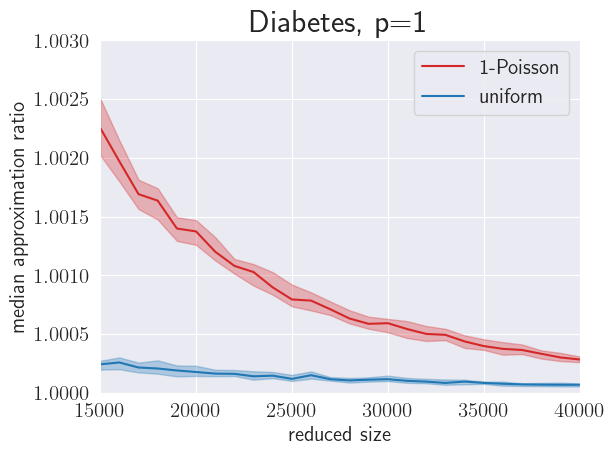

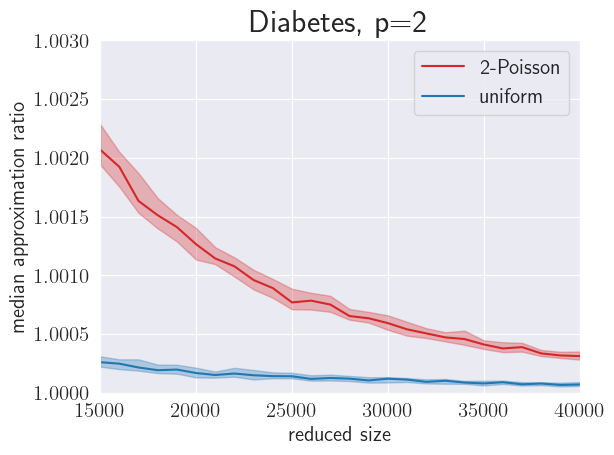

In [19]:
make_ratio_plot(Diabetes(p=1), p=1, methods=["leverage", "uniform"], x_min=15000, x_max=40000, y_min=1, y_max=1.003)
make_ratio_plot(Diabetes(p=2), p=2, methods=["leverage", "uniform"], x_min=15000, x_max=40000, y_min=1, y_max=1.003)

C:\Users\Traitor\AppData\Local\Temp\ipykernel_32704\2329922999.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap(name="tab20")


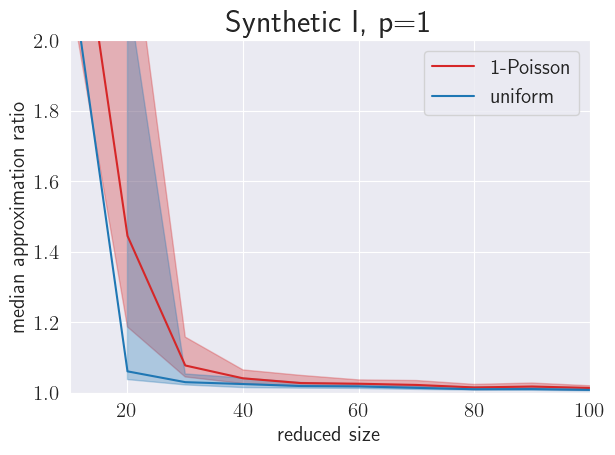

In [20]:
make_ratio_plot(Synthetic(n=100000, d=6, p=1, variant=1, seed=3), p=1, methods=["leverage", "uniform"], x_min=10, x_max=100, y_min=1, y_max=2)